## Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
print('Tensorflow Version: ', tf.__version__)

%matplotlib inline
plt.style.use('ggplot')
np.random.seed(0)

Tensorflow Version:  2.1.0


## Load and Explore Dataset

In [8]:
data = pd.read_csv('ner_dataset.csv', encoding = 'latin1')
data = data.fillna(method = 'ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [9]:
print('Unique words in corpus: ', data['Word'].nunique())
print('Unique tags in corpus:', data['Tag'].nunique())

Unique words in corpus:  35178
Unique tags in corpus: 17


In [11]:
words = list(set(data['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [12]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [13]:
num_words, num_tags

(35179, 17)

## Retrieve sentences and corrosponding tags

In [14]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                          s['POS'].values.tolist(),
                                                          s['Tag'].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [15]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [18]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

## Defining Mapping between Sentences and Tags

In [19]:
word2idx = {w:i+1 for i, w in enumerate(words)}
tag2idx = {t:i for i, t in enumerate(tags)}

In [20]:
word2idx

{'explosives-filled': 1,
 'Areas': 2,
 'buyouts': 3,
 '376-7': 4,
 'local-level': 5,
 'Hong-ryon': 6,
 'Kutesa': 7,
 'Gabriele': 8,
 '4,200': 9,
 'avid': 10,
 'testifies': 11,
 'step-grandmother': 12,
 'reform-minded': 13,
 'unsure': 14,
 'Endangered': 15,
 'spending': 16,
 '1.85': 17,
 'Mastung': 18,
 'belatedly': 19,
 'contempt': 20,
 'Philosopher': 21,
 'Mizhir': 22,
 'Swiss': 23,
 'averted': 24,
 'Adolf': 25,
 'flight': 26,
 'Pirates': 27,
 'northwestern': 28,
 'Kam': 29,
 '3,000-meters': 30,
 'Erben': 31,
 'Images': 32,
 'barcode': 33,
 'depict': 34,
 'Valparaiso': 35,
 'adds': 36,
 'dusk': 37,
 'once': 38,
 'Atalay': 39,
 'Des': 40,
 'Joanne': 41,
 'insurgency': 42,
 'far-western': 43,
 'Phan': 44,
 'Lords': 45,
 'higher': 46,
 'submit': 47,
 'court-martial': 48,
 'century': 49,
 'Editors': 50,
 'Hauts-de-Seine': 51,
 'Goose': 52,
 '128-member': 53,
 'Missile': 54,
 'extended': 55,
 'SCIRI': 56,
 'Akhrorkhodzha': 57,
 'broker': 58,
 'Prithvi': 59,
 'airfare': 60,
 'Shaab': 61,
 '

In [21]:
tag2idx

{'B-org': 0,
 'I-art': 1,
 'I-per': 2,
 'O': 3,
 'I-nat': 4,
 'B-eve': 5,
 'B-per': 6,
 'B-nat': 7,
 'B-gpe': 8,
 'I-geo': 9,
 'B-tim': 10,
 'I-gpe': 11,
 'I-org': 12,
 'I-eve': 13,
 'I-tim': 14,
 'B-art': 15,
 'B-geo': 16}

## Padding Input Sentences and Creating Train/Test Splits

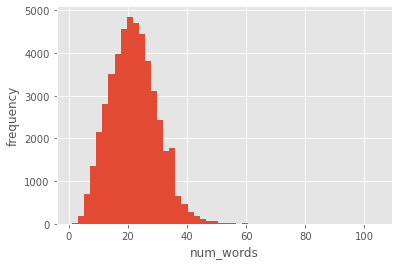

In [26]:
plt.hist([len(s) for s in sentences], bins = 50)
plt.xlabel("num_words")
plt.ylabel("frequency")
plt.show()

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag2idx["O"])
y = [to_categorical(i, num_classes = num_tags) for i in y]

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)

## Build and Compile a Bidirectional LSTM Model

In [36]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [38]:
input_word = Input(shape = (max_len, ))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags, activation = "softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(optimizer = "adam", 
             loss = "categorical_crossentropy",
             metrics = ['accuracy'])

## Train the Model

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [42]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 1, verbose = 0, mode = 'max')
callbacks = [early_stopping]

history = model.fit(X_train, np.array(y_train),
                   validation_split = 0.2,
                   batch_size = 32,
                   epochs = 3,
                   verbose = 1,
                   callbacks = callbacks)

Train on 34530 samples, validate on 8633 samples
Epoch 1/3
34530/34530 [==============================] - 167s 5ms/sample - loss: 0.1901 - accuracy: 0.9558 - val_loss: 0.0691 - val_accuracy: 0.9798
Epoch 2/3
34530/34530 [==============================] - 156s 5ms/sample - loss: 0.0536 - accuracy: 0.9842 - val_loss: 0.0502 - val_accuracy: 0.9847
Epoch 3/3
34530/34530 [==============================] - 155s 4ms/sample - loss: 0.0383 - accuracy: 0.9883 - val_loss: 0.0471 - val_accuracy: 0.9855


## Evaluation of Model

In [43]:
model.evaluate(X_test, np.array(y_test))

4796/4796 [==============================] - 4s 742us/sample - loss: 0.0487 - accuracy: 0.9854


[0.048744376627627366, 0.9853753]

In [48]:
i = np.random.randint(0, X_test.shape[0])
predict = model.predict(np.array([X_test[i]]))
predict = np.argmax(predict, axis = -1)

y_true = np.argmax(np.array(y_test), axis = -1)[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-"*30)
for w, true, pred in zip(X_test[i], y_true, predict[0]):
    print("{:15}{:5}\t {}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
Shaima         B-per	 B-per
Rezayee        I-per	 B-per
had            O    	 O
presented      O    	 O
a              O    	 O
music          O    	 O
program        O    	 O
on             O    	 O
the            O    	 O
privately-run  O    	 O
television     O    	 O
channel        O    	 O
Tolo           B-org	 B-org
TV             I-org	 I-org
,              O    	 O
and            O    	 O
was            O    	 O
shot           O    	 O
in             O    	 O
the            O    	 O
head           O    	 O
in             O    	 O
the            B-geo	 O
Kabul          I-geo	 B-geo
neighborhood   O    	 O
of             O    	 O
Char           B-org	 B-geo
Qala           I-org	 I-geo
on             O    	 O
Wednesday      B-tim	 B-tim
.              O    	 O
agreement      O    	 O
agreement      O    	 O
agreement      O    	 O
agreement      O    	 O
agreement      O    	 O
agreement      O    	 O
agreement      O    	